In [22]:

import numpy as np
import pandas as pd, re

#DEFINE CONSTANTS
MODERATE_EXPR_MU = 15
EXP_MODERATE_EXPR_MU = 3.3


### LOAD MOTIFS ###

In [23]:
import z2_save_jaspar, z1_save_oligos
jaspar = z2_save_jaspar.load_jaspar()
oligos,oligos_by_exp = z1_save_oligos.load_oligos()

## V2 ANALYSIS ##
Run a modified version of the above analysis, treating wild-type and non wt oligos seperately. Normalizing to an enrichment level of 1 in the pooled data, weight each experiment properly by total number of reads. For each experiment in the weighted pools, identify all adjacent pairs of WT oligos which are both expressed at a moderately enriched level. Looking at each pair in turn, evaluate whether (1) a single ablation, or (2) a double ablation candidate significantly diminishes expression, defining a significant reduction as one which diminishes expression to WT - std(local_wildtype) [check this]. Yield the following list of 60bp enhancer sequences and test for motifs

In [24]:
#LOADS BIOLOGICAL MOTIFS AND SCANS ALL SUBREGIONS FOR OCCURENCES
from pyfaidx import Fasta
sequences_fa = Fasta('/cluster/bh0085/genomes/GRCh38.primary_assembly.genome.fa')
chrseq = str(sequences_fa["chr22"])
region_bounds=[ 38699734, 39291007]

all_60bp_subregions = pd.DataFrame()
subregions = None
for k,g in oligos_by_exp.groupby(level = "exp"):
    wt_oligos = g.loc[g.mutant_num == 0] 
    mean_mu = wt_oligos.mu.mean()
    enriched_mu = EXP_MODERATE_EXPR_MU
    enriched_wt_oligos = wt_oligos.loc[wt_oligos.mu > enriched_mu]
    enriched_wt_starts = enriched_wt_oligos.starts.unique()
    non_enriched_mutants = g.loc[(g.mu<enriched_mu) & (g.mutant_num > 0) & (g.starts.isin(enriched_wt_starts))]
    motif_30bp_genome_start_proposals = pd.Series(non_enriched_mutants.mutant_start.unique()) + oligos_by_exp.gstart.min()
    motif_60bp_subregions = motif_30bp_genome_start_proposals.apply(lambda x: chrseq[x - 15 : x+45])
    if subregions is None:
        subregions = pd.DataFrame(motif_60bp_subregions.rename("seq")).assign(exp=k)
    else:
        subregions = pd.concat([subregions, pd.DataFrame(motif_60bp_subregions.rename("seq")).assign(exp=k)],ignore_index = True)


In [27]:
from Bio import Seq, Alphabet
regions60  = pd.DataFrame(pd.Series(subregions.seq.unique()).rename("seq")).reset_index().set_index("seq").apply(lambda x: Seq.Seq(x.name,alphabet=Alphabet.IUPAC.IUPACUnambiguousDNA()),axis=1)
pwm_r60_grid = jaspar.pssm.apply(lambda  pssm: regions60.apply(lambda x:  sorted(pssm.search(x),key=lambda x:-1*x[1])))
pwm_r60_scores_grid = pwm_r60_grid.unstack().apply(lambda x: 0 if len(x)==0 else x[0][1]).unstack().T
pwm_r60_indices_grid = pwm_r60_grid.unstack().apply(lambda x: 0 if len(x)==0 else x[0][0]).unstack().T


## What motif hits will be treated signficant? ## 
We are scoring ~500 motifs of varying lengths in this dataset. For each motif, we would like to say whether a given enhancer has a significant hit for that motif. Additive scoring of log odds for a position weight matrix will be higher for longer motifs. To judge relative goodness-of-fit for motifs of different lengths, we need to determine the expected score and standard deviation of each motif in the background. From this, we will compute a zscore for each possible motif hit. The two-std threshold of this z-score will be used to label motif hits and misses going forward. 

In [47]:
r60_max_motif_ids = pd.DataFrame(pwm_r60_scores_grid.idxmax().rename("motif_id"))
r60_max_motif_ids.to_csv("../data/0711_motif_manyregions_allbest.csv")
subregions.to_csv("../data/0711_manyregions.csv")

rc = lambda x: "".join([{"A":"T","G":"C","C":"G","T":"A"}[l] for l in x][::-1])
r60_max_centroids = r60_max_motif_ids.motif_id.apply(lambda x: jaspar.km_centroid_jaspar_id.get(x)).rename("cluster_centroid")
r60_km_cluster_ids = r60_max_motif_ids.motif_id.apply(lambda x: jaspar.km_cluster_id.get(x)).rename("km_cluster_id")
r60_spec2_cluster_ids = r60_max_motif_ids.motif_id.apply(lambda x: jaspar.spec2_cluster_id.get(x)).rename("spec2_cluster_id")
r60_spec3_cluster_ids = r60_max_motif_ids.motif_id.apply(lambda x: jaspar.spec3_cluster_id.get(x)).rename("spec3_cluster_id")
r60_ms_cluster_ids = r60_max_motif_ids.motif_id.apply(lambda x: jaspar.ms_cluster_id.get(x)).rename("ms_cluster_id")

r60_motif_positions = r60_max_motif_ids.apply(lambda x: pwm_r60_indices_grid[x.name].loc[x].values[0],axis=1).rename("position")
r60_motif_scores = r60_max_motif_ids.apply(lambda x: pwm_r60_scores_grid[x.name].loc[x].values[0],axis=1).rename("score")

r60_motif_lens = r60_max_motif_ids.apply(lambda x: jaspar.loc[x]["len"].values[0],axis=1).rename("motif_len")



r60_motif_seqs = pd.DataFrame(r60_motif_positions.reset_index().apply(lambda x: x.seq[x.position:x.position+r60_motif_lens.loc[x.seq]]
                                               if x.position >= 0 
                                               else rc(x.seq[60+x.position:60+x.position+r60_motif_lens.loc[x.seq]]),axis=1)\
    .rename("motif_actual_seq")).set_index(r60_motif_positions.index).motif_actual_seq

r60 = pd.concat([r60_max_motif_ids,r60_max_centroids,
                 r60_km_cluster_ids,r60_ms_cluster_ids,r60_spec3_cluster_ids,r60_spec2_cluster_ids,
                 r60_motif_positions,
                 r60_motif_scores,r60_motif_lens,r60_motif_seqs],axis =1)



In [33]:
match60_positions = r60.apply(lambda x: [e.start() for e in re.compile(x.name).finditer(chrseq[oligos.gstart.min():oligos.gend.max()])][0],axis=1)
match_motif_positions = (match60_positions + (r60.position + ((r60.position < 0) * 60)))
r60["motif_starts"] = match_motif_positions

motifs = r60.drop_duplicates("motif_starts").reset_index(drop=True)
readout = None

for k,multiindexed_oligos in oligos_by_exp.groupby(["exp_nm","rep"]):
    these_oligos = multiindexed_oligos.reset_index(level=0)
    #these_oligos = oligos
    overlapping_oligo_starts = motifs.apply(lambda x: these_oligos.loc[(these_oligos.starts < x.motif_starts) & (these_oligos.starts > x.motif_starts - 120)].starts.unique(),axis =1)
    overlapping_wt_oligos = overlapping_oligo_starts.apply(lambda x: these_oligos.loc[these_oligos.starts.isin(x) & (these_oligos.mutant_num == 0)].RefSeqID)
    overlapping_mutant_oligos = motifs.apply(lambda x:these_oligos.loc[(these_oligos.mutant_start < (x.motif_starts+30)) & (these_oligos.mutant_start> (x.motif_starts - 30 ))].RefSeqID,axis=1)
    motif_overlap_wt_refseqs = overlapping_wt_oligos.stack()
    motif_overlap_mutant_refseqs = overlapping_mutant_oligos.stack()
    
    motif_mutant_mu = motif_overlap_mutant_refseqs.groupby(level=0).apply(lambda x:these_oligos.set_index("RefSeqID").loc[x].mu.mean()).rename("mutant_mu")
    motif_wt_mu = motif_overlap_wt_refseqs.groupby(level=0).apply(lambda x:these_oligos.set_index("RefSeqID").loc[x].mu.mean()).rename("wt_mu")
    motif_mutant_mu.index.name = "motif"
    motif_wt_mu.index.name = "motif"
    motifs.index.name = "motif"
    
    muvals =  pd.concat([motif_mutant_mu,motif_wt_mu],axis=1)
    muvals["exp_nm"]=k[0]
    muvals["rep"]=k[1]
    if readout is None:
        readout = muvals
    else:
        readout = pd.concat([readout,muvals])

readout = readout.join(motifs[["km_cluster_id","ms_cluster_id","spec2_cluster_id","spec3_cluster_id"]],on="motif")
readout["rep"] = readout.rep.astype(np.int32)
melted = readout.reset_index().melt(value_name= "mu_val",var_name="mu_type",value_vars = ["mutant_mu","wt_mu"],id_vars=["exp_nm","rep","motif","ms_cluster_id","spec2_cluster_id","spec3_cluster_id","km_cluster_id"])


In [38]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

<Figure size 432x288 with 0 Axes>

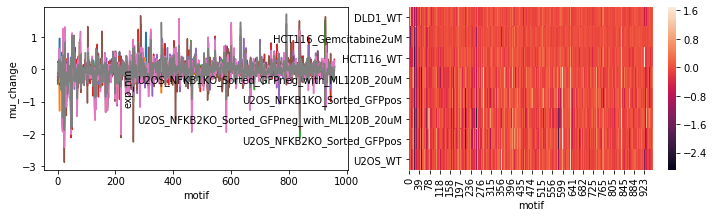

<Figure size 432x288 with 0 Axes>

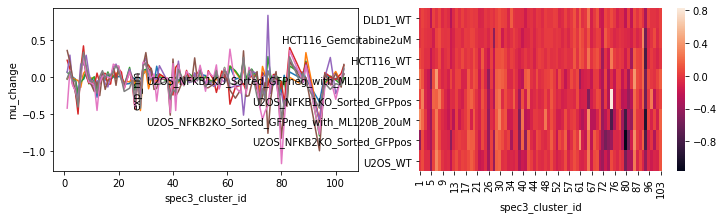

<Figure size 432x288 with 0 Axes>

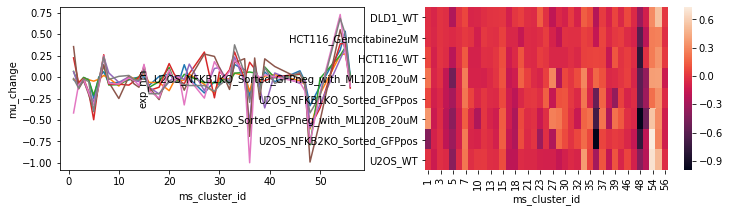

<Figure size 432x288 with 0 Axes>

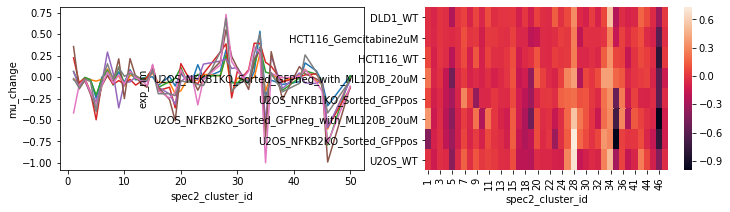

In [39]:
for clustering in ["motif","spec3_cluster_id","ms_cluster_id", "spec2_cluster_id",]:
    plt.figure()
    f,subs = plt.subplots(1,2)
    f.set_size_inches(12,3)
    mus_by_cluster = melted.groupby([clustering,"exp_nm","mu_type"]).mu_val.mean()
    deltas_stacked = (np.log2(mus_by_cluster.unstack(level="mu_type").mutant_mu / mus_by_cluster.unstack(level="mu_type").wt_mu).rename("mu_change"))
    deltas_by_cluster = deltas_stacked.unstack(level="exp_nm")
    plt.sca(subs[0])
    g = sns.lineplot(x=clustering, y="mu_change", hue="exp_nm", data = deltas_stacked.reset_index())
    #g._legend.remove()
    g.legend().set_visible(False)
    plt.sca(subs[1])
    
    sns.heatmap(data = deltas_stacked.unstack(level=0).fillna(0))
    
    #plt.legend(loc=[1,0])


<Figure size 576x360 with 0 Axes>

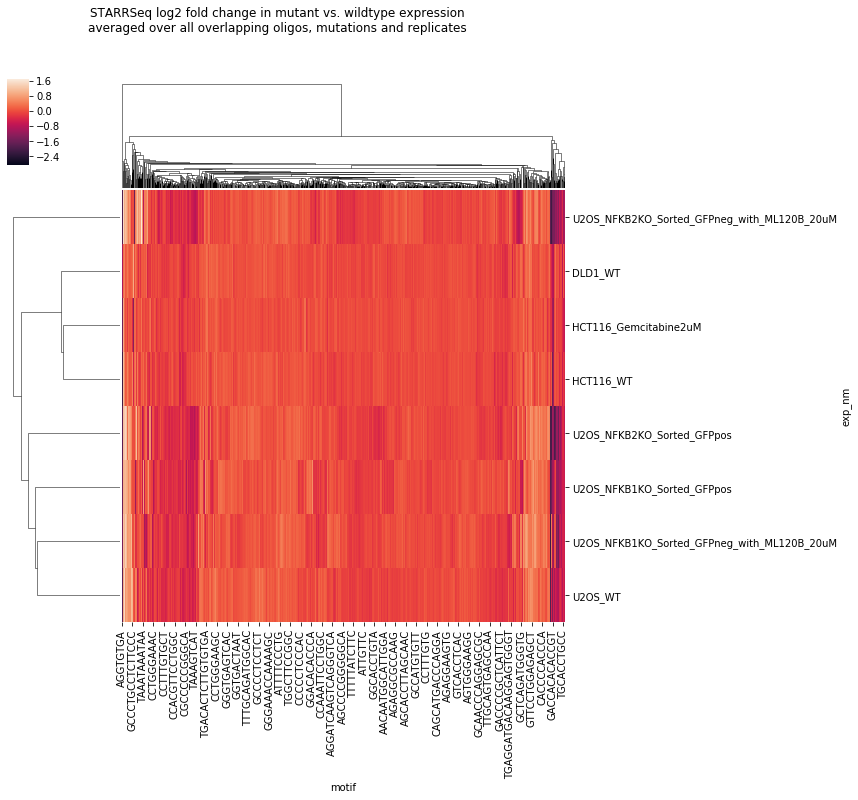

<Figure size 576x360 with 0 Axes>

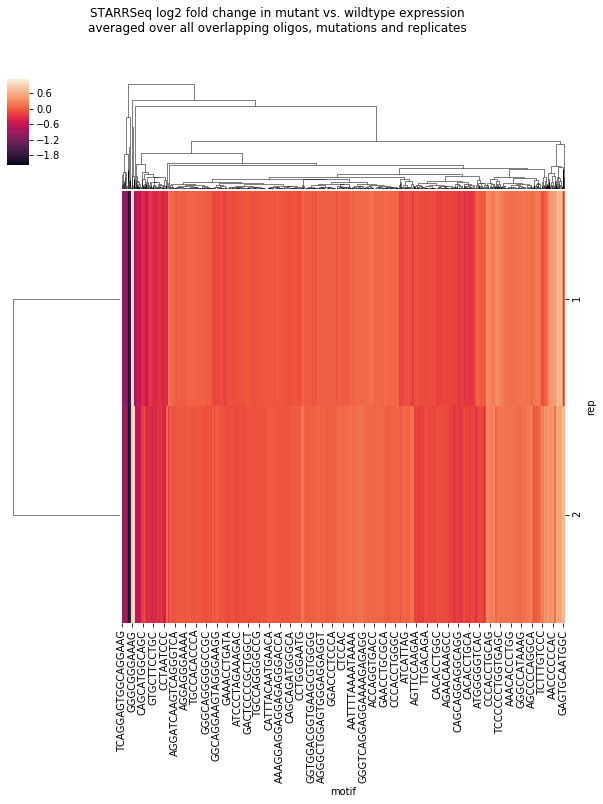

<Figure size 432x288 with 0 Axes>

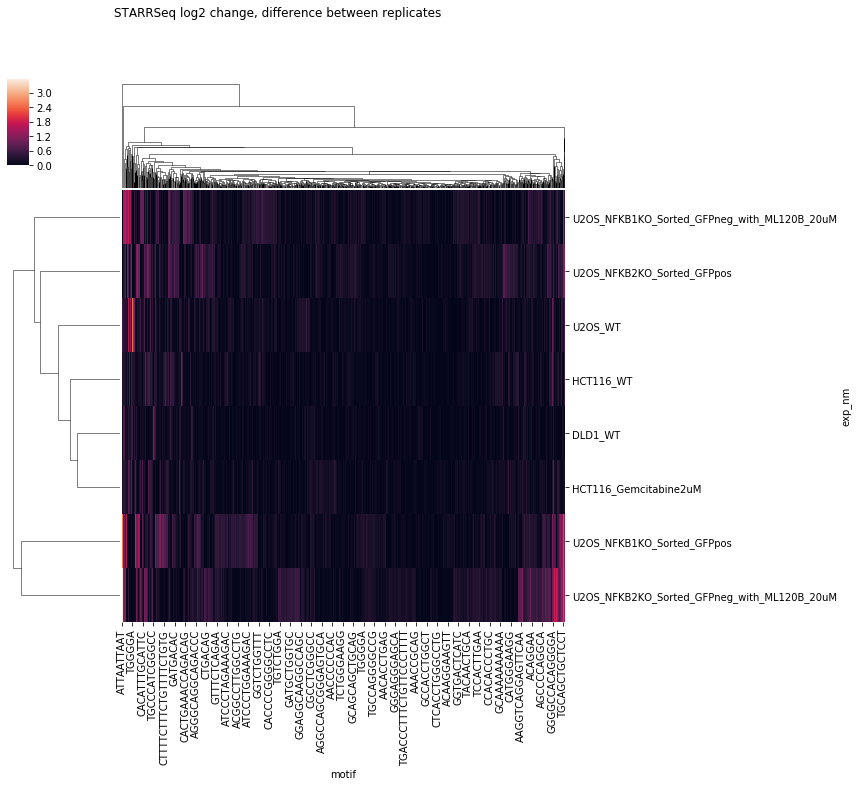

<Figure size 432x288 with 0 Axes>

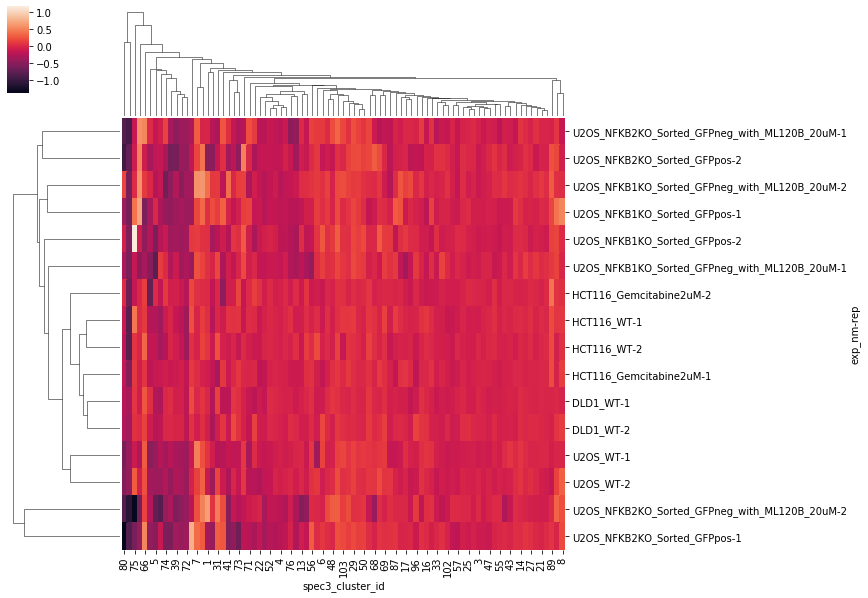

<Figure size 432x288 with 0 Axes>

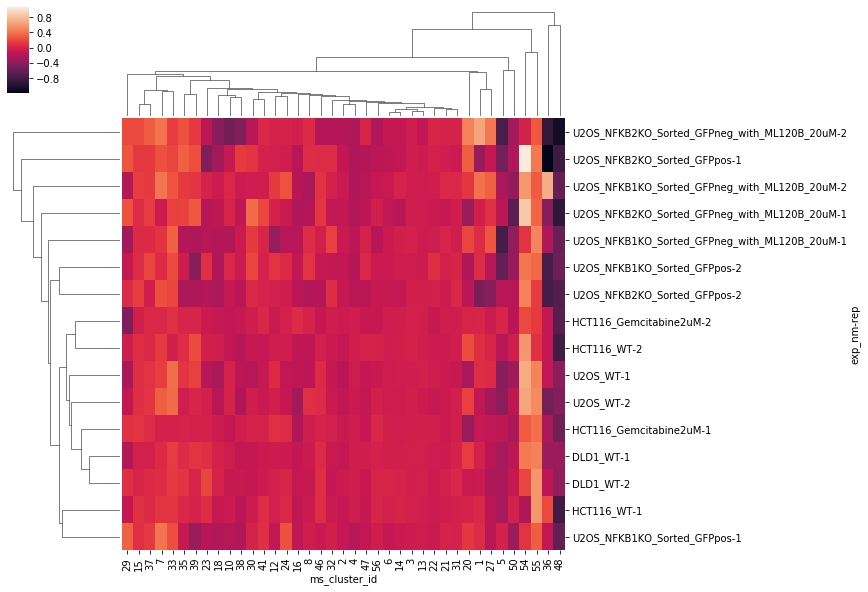

In [40]:
clustering = "motif"
f = plt.figure()
f.set_size_inches(8,5)
mus_by_cluster = melted.groupby([clustering,"exp_nm","mu_type"]).mu_val.mean()
deltas_stacked = (np.log2(mus_by_cluster.unstack(level="mu_type").mutant_mu / mus_by_cluster.unstack(level="mu_type").wt_mu).rename("mu_change"))
deltas_by_cluster = deltas_stacked.unstack(level=["exp_nm"])
#sns.heatmap(x=clustering, y="mu_change", hue="exp_nm", data = deltas_stacked.reset_index())
#plt.legend(loc=[1,0])a

deltas_cluster_exp =  deltas_stacked.unstack(level=clustering).fillna(0)
motif_lookup = motifs.reset_index()[["motif_actual_seq",clustering]].groupby(clustering).first()["motif_actual_seq"]
deltas_exemplar_exp = deltas_cluster_exp.rename(lambda x: motif_lookup.loc[x], axis="columns")
p1 = sns.clustermap(data =deltas_exemplar_exp)

ax = plt.gca()
p1.fig.suptitle("STARRSeq log2 fold change in mutant vs. wildtype expression\naveraged over all overlapping oligos, mutations and replicates")


clustering = "motif"
f = plt.figure()
f.set_size_inches(8,5)
mus_by_cluster = melted.groupby([clustering,"rep","mu_type"]).mu_val.mean()
deltas_stacked = (np.log2(mus_by_cluster.unstack(level="mu_type").mutant_mu / mus_by_cluster.unstack(level="mu_type").wt_mu).rename("mu_change"))
deltas_by_cluster = deltas_stacked.unstack(level=["rep"])
#sns.heatmap(x=clustering, y="mu_change", hue="exp_nm", data = deltas_stacked.reset_index())
#plt.legend(loc=[1,0])a

deltas_cluster_exp =  deltas_stacked.unstack(level=clustering).fillna(0)
motif_lookup = motifs.reset_index()[["motif_actual_seq",clustering]].groupby(clustering).first()["motif_actual_seq"]
deltas_exemplar_exp = deltas_cluster_exp.rename(lambda x: motif_lookup.loc[x], axis="columns")
p1 = sns.clustermap(data =deltas_exemplar_exp)

ax = plt.gca()
p1.fig.suptitle("STARRSeq log2 fold change in mutant vs. wildtype expression\naveraged over all overlapping oligos, mutations and replicates")




clustering = "motif"
plt.figure()

mus_by_cluster = melted.groupby([clustering,"exp_nm","rep","mu_type"]).mu_val.mean()
deltas_stacked = (np.log2(mus_by_cluster.unstack(level="mu_type").mutant_mu / mus_by_cluster.unstack(level="mu_type").wt_mu).rename("mu_change"))
deltas_unstacked_twice = (np.abs(deltas_stacked.unstack(level="rep")[2] - deltas_stacked.unstack(level="rep")[1])).rename("rep_change")

#deltas_by_cluster = deltas_unstacked_twice.unstack(level=["exp_nm"])
#sns.heatmap(x=clustering, y="mu_change", hue="exp_nm", data = deltas_stacked.reset_index())
#plt.legend(loc=[1,0])a

deltas_cluster_exp =  deltas_unstacked_twice.unstack(level=clustering).fillna(0)
motif_lookup = motifs.reset_index()[["motif_actual_seq",clustering]].groupby(clustering).first()["motif_actual_seq"]
deltas_exemplar_exp = deltas_cluster_exp.rename(lambda x: motif_lookup.loc[x], axis="columns")
p1 = sns.clustermap(data =deltas_exemplar_exp)

ax = plt.gca()
p1.fig.suptitle("STARRSeq log2 change, difference between replicates")

#p1.set_xlabels(motif_lookup.)

clustering = "spec3_cluster_id"
plt.figure()
mus_by_cluster = melted.groupby([clustering,"exp_nm","rep","mu_type"]).mu_val.mean()
deltas_stacked = (np.log2(mus_by_cluster.unstack(level="mu_type").mutant_mu / mus_by_cluster.unstack(level="mu_type").wt_mu).rename("mu_change"))
deltas_by_cluster = deltas_stacked.unstack(level=["exp_nm","rep"])
#sns.heatmap(x=clustering, y="mu_change", hue="exp_nm", data = deltas_stacked.reset_index())
#plt.legend(loc=[1,0])
sns.clustermap(data = deltas_stacked.unstack(level=0).fillna(0))


clustering = "ms_cluster_id"
plt.figure()
mus_by_cluster = melted.groupby([clustering,"exp_nm","rep","mu_type"]).mu_val.mean()
deltas_stacked = (np.log2(mus_by_cluster.unstack(level="mu_type").mutant_mu / mus_by_cluster.unstack(level="mu_type").wt_mu).rename("mu_change"))
deltas_by_cluster = deltas_stacked.unstack(level=["exp_nm","rep"])
#sns.heatmap(x=clustering, y="mu_change", hue="exp_nm", data = deltas_stacked.reset_index())
#plt.legend(loc=[1,0])
sns.clustermap(data = deltas_stacked.unstack(level=0).fillna(0))




In [ ]:
import seaborn as sns

In [ ]:
f = plt.gcf()
f.set_size_inches(14,6)

n_colors = 256 # Use 256 colors for the diverging color palette
palette = sns.diverging_palette(20, 220, n=n_colors) # Create the palette
color_min, color_max = [-1, 1] # Range of values that will be mapped to the palette, i.e. min and max possible correlation

def value_to_color(val):
    val_position = float((val - color_min)) / (color_max - color_min) # position of value in the input range, relative to the length of the input range
    ind = int(val_position * (n_colors - 1)) # target index in the color palette
    return palette[ind]

ax = plt.gca()
ax.scatter(
    y=r60_max_centroids,
    x=range(len(r60_max_centroids)),
    s=r60_motif_scores / max(r60_motif_scores)*50,
    c=((r60_motif_scores / max(r60_motif_scores) - .5)*2).astype(float).apply(value_to_color), # Vector of square color values, mapped to color palette
    marker='s'
)

In [ ]:
pwm_r60_grid.shape

In [ ]:
pwm_r60_indices_grid.shape

## 0629 EARLY ANALYSIS QUESTIONS ##

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
